# Model Card Toolkit

This notebook has example code to train a custom model and produce a model card using [Model Card Toolkit](https://www.tensorflow.org/responsible_ai/model_card_toolkit/guide) and Vertex AI Pipelines. This is a classification model using the inbuilt sklearn breast cancer dataset to classify images, modifying the example [here](https://colab.research.google.com/github/tensorflow/model-card-toolkit/blob/master/model_card_toolkit/documentation/examples/Scikit_Learn_Model_Card_Toolkit_Demo.ipynb) to produce the card in a pipeline.

In [ ]:
# Install required libraries to submit pipeline
# !pip install kfp==1.8.17 google-cloud-aiplatform

In [ ]:
import json
import kfp
from google.cloud import aiplatform
from kfp.v2 import dsl
from kfp.v2.dsl import Output, HTML, component

In [ ]:
project_id = "<PROJECT_ID>"
pipeline_root = "gs://<GCS_ROOT_BUCKET>"
location = "europe-west1"
service_account = "<SERVICE_ACCOUNT>"

In [ ]:
@component(
    base_image="python:3.7",
    packages_to_install=["scikit-learn", "model-card-toolkit", "pandas", "matplotlib", "seaborn"],
)
def generate_model_card(
    model_card: Output[HTML]
) -> None:
    """
    Train a classifier and generate an associated model card.
    Args:
        model_card (Output[HTML]): Output artifact to view the model card.
    Returns:
        None
    """
    from datetime import date
    from io import BytesIO
    import model_card_toolkit as mctlib

    from sklearn.datasets import load_breast_cancer
    from sklearn.ensemble import GradientBoostingClassifier
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import (RocCurveDisplay, ConfusionMatrixDisplay, PrecisionRecallDisplay, 
                                 accuracy_score, precision_score, recall_score, 
                                 f1_score, roc_auc_score, matthews_corrcoef)

    import os
    import logging
    import base64
    import matplotlib.pyplot as plt
    import pandas as pd
    import seaborn as sns

    logging.getLogger().setLevel(logging.INFO)

    logging.info("Load sklearn inbuilt breast cancer data")
    cancer = load_breast_cancer()

    X = pd.DataFrame(cancer.data, columns=cancer.feature_names)
    y = pd.Series(cancer.target)

    X_train, X_test, y_train, y_test = train_test_split(X, y)

    logging.info("Train classifier")
    clf = GradientBoostingClassifier().fit(X_train, y_train)

    # Utility function that will export a plot to a base-64 encoded string that the model card will accept.
    def plot_to_str():
        img = BytesIO()
        plt.savefig(img, format='png')
        return base64.encodebytes(img.getvalue()).decode('utf-8')

    # Plot the mean radius feature for both the train and test sets
    sns.displot(x=X_train['mean radius'], hue=y_train)
    mean_radius_train = plot_to_str()
    sns.displot(x=X_test['mean radius'], hue=y_test)
    mean_radius_test = plot_to_str()

    # Plot the mean texture feature for both the train and test sets
    sns.displot(x=X_train['mean texture'], hue=y_train)
    mean_texture_train = plot_to_str()
    sns.displot(x=X_test['mean texture'], hue=y_test)
    mean_texture_test = plot_to_str()

    # Calculate metrics of classifier that will be displayed in the model card
    logging.info("Calculate metrics of classifier")
    
    # Plot ROC curve
    RocCurveDisplay.from_estimator(clf, X_test, y_test)
    roc_curve = plot_to_str()

    # Plot confusion matrix
    ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)
    confusion_matrix = plot_to_str()

    # Plot precision-recall curve
    PrecisionRecallDisplay.from_estimator(clf, X_test, y_test)
    precision_recall = plot_to_str()
    
    # Calculate various metrics
    y_pred = clf.predict(X_test)
    accuracy = round(accuracy_score(y_test, y_pred), 4)
    precision = round(precision_score(y_test, y_pred), 4)
    recall = round(recall_score(y_test, y_pred), 4)
    f1 = round(f1_score(y_test, y_pred), 4)
    auc = round(roc_auc_score(y_test, y_pred), 4)
    mcc = round(matthews_corrcoef(y_test, y_pred), 4)
    
    logging.info("Initialise model card")
    mct = mctlib.ModelCardToolkit()

    mc = mct.scaffold_assets()
    mct.update_model_card(mc)

    mc.model_details.name = 'Breast Cancer Wisconsin (Diagnostic) Dataset'
    mc.model_details.overview = (
        'This model predicts whether breast cancer is benign or malignant based on '
        'image measurements.')

    mc.model_details.references = [
        mctlib.Reference(reference='https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)'),
        mctlib.Reference(reference='https://minds.wisconsin.edu/bitstream/handle/1793/59692/TR1131.pdf')
    ]
    mc.model_details.version.name = "Breast Cancer Model Card"
    mc.model_details.version.date = str(date.today())

    mc.considerations.ethical_considerations = [mctlib.Risk(
        name=('Manual selection of image sections to digitize could create '
                'selection bias'),
        mitigation_strategy='Automate the selection process'
    )]
    mc.considerations.limitations = [mctlib.Limitation(description='Breast cancer diagnosis')]
    mc.considerations.use_cases = [mctlib.UseCase(description='Breast cancer diagnosis')]
    mc.considerations.users = [mctlib.User(description='Medical professionals'), mctlib.User(description='ML researchers')]

    logging.info("Add statistics and metrics to model card")
    mc.model_parameters.data.append(mctlib.Dataset())
    mc.model_parameters.data[0].graphics.description = (
      f'{len(X_train)} rows with {len(X_train.columns)} features')
    mc.model_parameters.data[0].graphics.collection = [
        mctlib.Graphic(image=mean_radius_train),
        mctlib.Graphic(image=mean_texture_train)
    ]
    
    mc.model_parameters.data.append(mctlib.Dataset())
    mc.model_parameters.data[1].graphics.description = (
      f'{len(X_test)} rows with {len(X_test.columns)} features')
    mc.model_parameters.data[1].graphics.collection = [
        mctlib.Graphic(image=mean_radius_test),
        mctlib.Graphic(image=mean_texture_test)
    ]
    
    mc.quantitative_analysis.graphics.description = (
      'Confusion matrix, ROC curve and precision-recall curve')
    mc.quantitative_analysis.graphics.collection = [
        mctlib.Graphic(image=confusion_matrix),
        mctlib.Graphic(image=roc_curve),
        mctlib.Graphic(image=precision_recall)
    ]

    mc.quantitative_analysis.performance_metrics = [
      mctlib.PerformanceMetric(type='accuracy', value=str(accuracy)),
      mctlib.PerformanceMetric(type='precision', value=str(precision)),
      mctlib.PerformanceMetric(type='recall', value=str(recall)),
      mctlib.PerformanceMetric(type='f1', value=str(f1)),
      mctlib.PerformanceMetric(type='auc', value=str(auc)),
      mctlib.PerformanceMetric(type='mcc', value=str(mcc))
    ]

    mct.update_model_card(mc)

    # Write model card
    logging.info("Write model card to HTML")
    html = mct.export_format()
    # ensure view is stored as html (this will set content-type to text/html)
    if not model_card.path.endswith(".html"):
        model_card.path += ".html"

    # write html to output file
    with open(model_card.path, "w") as f:
        f.write(html)

In [ ]:
@kfp.dsl.pipeline(name="model-card-pipeline", pipeline_root=pipeline_root)
def pipeline(
):    
    model_card_op = generate_model_card(
    ).set_display_name("Generate model card for breast cancer data")

In [ ]:
from kfp.v2 import compiler

compiler.Compiler().compile(
    pipeline_func=pipeline,
    package_path="model_card_pipeline.json",
)

In [ ]:
# Configure the pipeline
job = aiplatform.PipelineJob(
    display_name="model-card-pipeline",
    template_path="model_card_pipeline.json",
    location=location,
    pipeline_root=pipeline_root,
    parameter_values={
    },
    enable_caching=False,
)

In [ ]:
# Run the job
job.submit(
    service_account=service_account)

Once the pipeline has successfully run, you can see the model card in a link through the UI directly. You can also download the HTML file and display elsewhere.

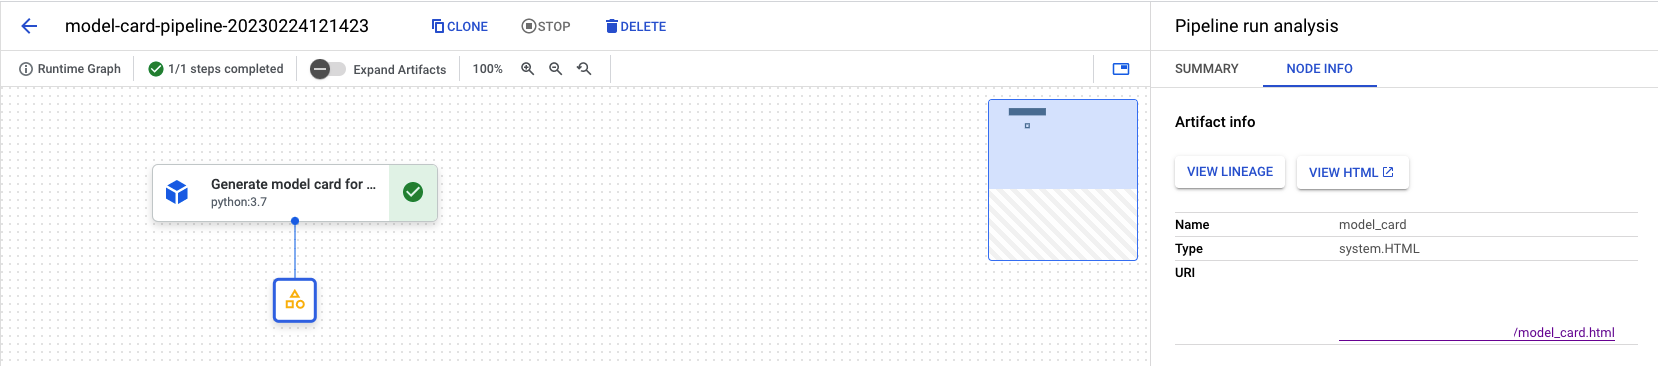

In [1]:
from IPython.display import HTML
HTML(filename='model_card.html')

Name,Value
accuracy,"0.965 (None, None)"
precision,"0.9565 (None, None)"
recall,"0.9888 (None, None)"
f1,"0.9724 (None, None)"
auc,"0.9573 (None, None)"
mcc,"0.9257 (None, None)"
